In [1]:
#imports
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import skimage.io
import datetime
import random
from scipy.signal import spectrogram

#PyTorch stuff
import torch
import torchvision as torchv
import torch.nn as nn 
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.datasets import ImageFolder
import gc

# File paths
TESTDIR = './../Data/ToyotaLc/'
TESTPATH = 'Lock/'
TESTSIG = 'keyfob_signal2023Y1022163258.raw'
TESTOUT = './../Data/MelSpecV1/Hyundai/'

IMG_SIZE=124
IMG_L = 124

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

classes = ('Lock', 'Unlock','None')
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:1024"
torch.cuda.set_per_process_memory_fraction(0.9)

In [2]:
# Define data transformations including normalization
mean = [0.485, 0.456, 0.406]  # Mean values for the ImageNet dataset
std = [0.229, 0.224, 0.225]   # Standard deviation values for the ImageNet dataset

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_L)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)  # Normalize with the specified mean and std
])

# Define the dataset using ImageFolder
dataset = ImageFolder(TESTOUT, transform=transform)

# Split the dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders for training and validation
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [3]:
data_iterator = iter(train_loader)
images, labels = next(data_iterator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


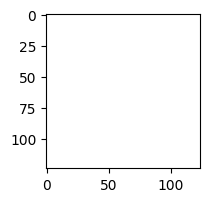

In [4]:
npimg = images[0].numpy()
# Display the image using matplotlib
plt.figure(figsize=(2,2))
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

In [5]:
def evaluation(net, dataloader, device):
    # calculate accuracy and loss
    total, correct = 0, 0
    loss_sum = 0.0
    num_batches = len(dataloader)

    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, pred = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
            loss = loss_fn(outputs, labels)
            loss_sum += loss.item()

    accuracy = 100 * correct / total
    loss = loss_sum / num_batches

    return accuracy, loss

In [6]:
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()

        # Stem
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Inception blocks (similar to Inception-ResNet)
        self.inception1 = InceptionBlock(64, 32, 64, 64, 64)  # Keep only one Inception block

        # Fully connected layers
        self.fc_model = nn.Sequential(
            nn.Linear(861056, 512),  # Adjust the input size based on the modified model
            nn.ReLU(),
            #nn.Dropout(p=0.1),
            nn.Linear(512, 3)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.inception1(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = nn.functional.softmax(x, dim=1)  # Apply softmax along the second dimension
        return x

class InceptionBlock(nn.Module):
    def __init__(self, in_channels, red_channels, mid1_channels, mid2_channels, out_channels):
        super(InceptionBlock, self).__init__()

        # 1x1 convolution branch
        self.branch1x1 = nn.Sequential(
            nn.Conv2d(in_channels, red_channels, 1),
            nn.ReLU()
        )

        # 1x1 convolution followed by 3x3 convolution branch
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, mid1_channels, 1),
            nn.ReLU(),
            nn.Conv2d(mid1_channels, mid2_channels, 3, padding=1),
            nn.ReLU()
        )

        # 1x1 convolution followed by 5x5 convolution branch
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, mid1_channels, 1),
            nn.ReLU(),
            nn.Conv2d(mid1_channels, mid2_channels, 5, padding=2),
            nn.ReLU()
        )

        # 3x3 max-pooling followed by 1x1 convolution branch
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_channels, 1),
            nn.ReLU()
        )

    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        branch_pool = self.branch_pool(x)
        return torch.cat([branch1x1, branch3x3, branch5x5, branch_pool], 1)


# Instantiate the deep CNN model
#model = DeepCNN()

In [7]:
# Training

net = DeepCNN().to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters(), lr=1e-6)

Epoch: 0/100, Validation Acc: 12.12, Training Acc: 20.31, Validation Loss: 1.2500
Epoch: 1/100, Validation Acc: 78.79, Training Acc: 82.81, Validation Loss: 0.7731
Epoch: 2/100, Validation Acc: 21.21, Training Acc: 18.75, Validation Loss: 1.2783
Epoch: 3/100, Validation Acc: 66.67, Training Acc: 73.44, Validation Loss: 0.8721
Epoch: 4/100, Validation Acc: 66.67, Training Acc: 75.00, Validation Loss: 0.8763
Epoch: 5/100, Validation Acc: 66.67, Training Acc: 74.22, Validation Loss: 0.8847
Epoch: 6/100, Validation Acc: 75.76, Training Acc: 76.56, Validation Loss: 0.7915
Epoch: 7/100, Validation Acc: 66.67, Training Acc: 73.44, Validation Loss: 0.8848
Epoch: 8/100, Validation Acc: 66.67, Training Acc: 75.00, Validation Loss: 0.8197
Epoch: 9/100, Validation Acc: 66.67, Training Acc: 73.44, Validation Loss: 0.8848
Epoch: 10/100, Validation Acc: 66.67, Training Acc: 73.44, Validation Loss: 0.8847
Epoch: 11/100, Validation Acc: 66.67, Training Acc: 73.44, Validation Loss: 0.8835
Epoch: 12/100,

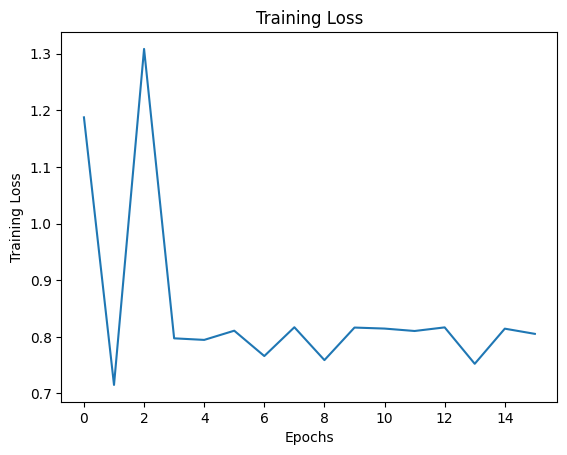

CPU times: user 30min 1s, sys: 2min 45s, total: 32min 47s
Wall time: 18min 46s


In [8]:
%%time
loss_arr = []
loss_epoch_arr = []
max_epochs = 100
patience = 15
min_loss_threshold = 1e-4  # Minimum improvement threshold
best_val_loss = float('inf')  # Initialize with a large value
epochs_without_improvement = 0

for epoch in range(max_epochs):
    net.train()  # Set the model to training mode

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        #inputs, labels = inputs.to(torch.float), labels.to(torch.float)
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        loss_arr.append(loss.item())

    net.eval()  # Set the model to evaluation mode

    # Calculate accuracy and loss on validation and training data
    val_accuracy, val_loss = evaluation(net, val_loader, device)
    train_accuracy, train_loss = evaluation(net, train_loader, device)
    
    # Check if the validation loss has improved
    if val_loss < best_val_loss - min_loss_threshold:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        best_weights = net.state_dict()
        best_epoch = epoch
    else:
        epochs_without_improvement += 1

    # Early stopping check
    if epochs_without_improvement >= patience:
        print(f"Early stopping after {patience} epochs without improvement.")
        print(f"Loading best weights from epoch {best_epoch}...")
        break

    loss_epoch_arr.append(train_loss)  # Use training loss for plotting
    
    print('Epoch: %d/%d, Validation Acc: %0.2f, Training Acc: %0.2f, Validation Loss: %0.4f' % (epoch, max_epochs, val_accuracy, train_accuracy, val_loss))

# Plot the training loss
plt.plot(loss_epoch_arr)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss")
plt.show()

In [ ]:
torch.save(best_weights, 'DenseCNN_weights_hyundai_V1')

In [ ]:
torch.save(net,'DenseCNN_model_hyundai_V1')